In [1]:
# Import dependencies
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Read in the census race data
block_2020 = pd.read_csv('data/nhgis0007_csv/nhgis0007_ds248_2020_block.csv', low_memory=False)

In [3]:
#Read in the shape data for geopandas
block_map_2020 = gpd.read_file('data/nhgis0008_shape/GA_block_2020.shp')

In [4]:
# Label the columns of interest
cols = ['GISJOIN', 'U7B001', 'U7B002', 'U7B003', 'U7B004', 'U7B005','U7B006','U7B007','U7B008']
# Locate the geoids for Atlanta
places = gpd.read_file('data/Census_Place_Data/cb_2020_13_place_500k.shp')
atlanta = places[places['NAME'] == 'Atlanta']

In [5]:
# print the dataframe for atlanta to get the PLACEFP
atlanta

,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
218,13,04000,02403126,1600000US1304000,1304000,Atlanta,Atlanta city,GA,Georgia,25,350456124,2585706,"MULTIPOLYGON (((-84.34767 33.78984, -84.34708 ..."


In [6]:
# Locate the blocks necessary for Atlanta
atlanta_blocks = block_2020[block_2020['PLACEA'] == 4000]
# Merge the Census data for atlanta with the spacial data for atlanta
atlanta_blocks_map = block_map_2020.merge(atlanta_blocks.loc[:, cols], how='inner', on='GISJOIN', validate='one_to_one')

In [7]:
# Print the coordinate reference system info for atlanta to get the authority code
atlanta.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
# Use the authority code to correct the gpd projection of Atlanta
atlanta_blocks_map = atlanta_blocks_map.to_crs("EPSG:4269")
# Normalize the value for the black population
atlanta_blocks_map['black_rate'] = atlanta_blocks_map['U7B004'] / atlanta_blocks_map['U7B001']

In [9]:
# Narrow down the year to 2020 and eliminate all zero value for long and lat
complete_crime = pd.read_csv("Crime Data.csv", low_memory=False)
is_2020 = complete_crime['occur_year'] == 2020
crime2020 = complete_crime[is_2020]
is_real = crime2020[['lat', 'long']] < 0 
acc_crime2020 = crime2020[is_real]

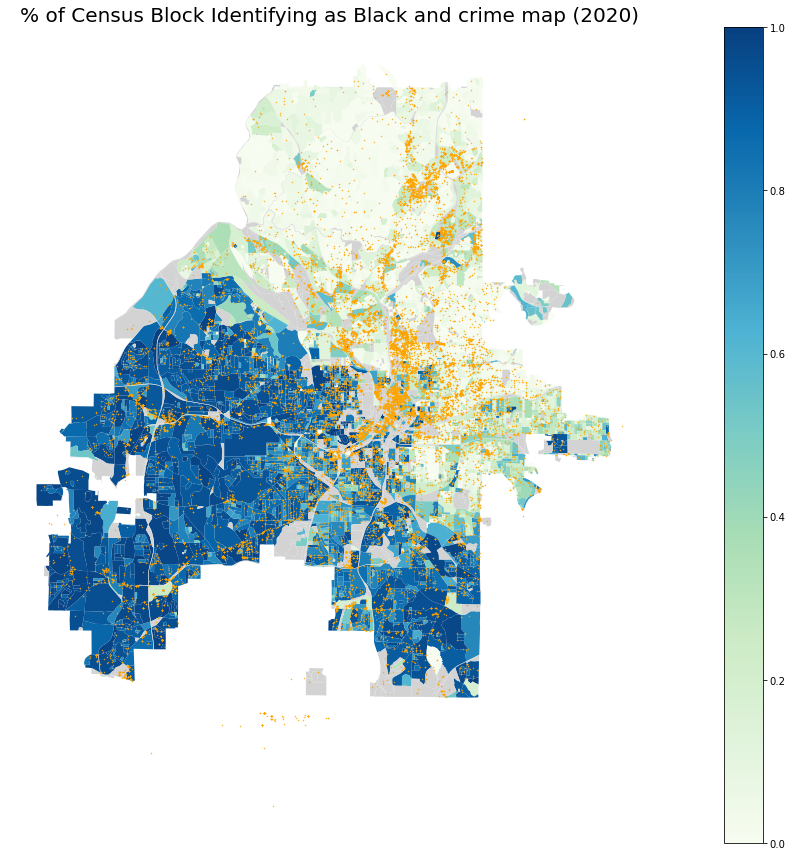

In [12]:
# Create the plot for the data
fig, ax = plt.subplots(figsize=(12,12))
# Allows manipulation of axes
divider = make_axes_locatable(ax)
# Determine the axes to draw into and move it to the right
cax = divider.append_axes("right", size="5%", pad=0.1)
# Plot the data from atlanta_blocks_map['black_rate'], color it, add a legend, axes, and allow coloring of missing data
atlanta_blocks_map.plot(ax=ax, 
                        column='black_rate', 
                        cmap='GnBu',
                        legend=True, 
                        cax=cax,
                        missing_kwds={"color": "lightgrey"},
                       )
# Create a title for the figure
ax.set_title('% of Census Block Identifying as Black and crime map (2020)', fontsize=20)
# Plot the location of all crime in 2020
ax.scatter(acc_crime2020['long'], crime2020['lat'], c='orange', s=0.2)
# Tidy up the axes
ax.axis('off')
# Tighten up the plot
plt.tight_layout()
# Create an image file 
plt.savefig('data/racial_crime_divide.png')